# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [126]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.serializers import CSVSerializer
from sagemaker.estimator import Estimator
import subprocess
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score


import math




# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Setup Sagemaker Session
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
execution_role = sagemaker.session.get_execution_role()
region = sagemaker_session.boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
#download data to notebook
#define data location constants
local_data_dir = 'data'
s3_data_path = f's3://{bucket}/data' 
s3_model_path = f's3://{bucket}/model'

## Initial Model 

Below I will be setting up the an initial AutoGluon run without any refienment of the data. 

In [4]:
%%capture --no-stderr

!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon #--no-cache-dir
from autogluon.tabular import TabularPredictor


In [132]:
from ag_model import (
    AutoGluonSagemakerInferenceModel
)

### Downloading and Prepping Data

In [10]:
train_data = pd.read_csv(f'{s3_data_path}/train.csv')

/tmp/ipykernel_10546/3792393069.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(f'{s3_data_path}/train.csv')


In [11]:
train_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [13]:
train_data.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


#### First Submission
To start for our first submission we're going to drop all the columns but the ones explored in the proposal section, this is simply to get a basic submission and baseline to compare against at the end of the project.

#### Drop Columns, DropNA, Normalize

In [14]:
train_data[['LNR', 'RESPONSE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'ANREDE_KZ']].describe()

,LNR,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ
count,42962.000000,42962.000000,42357.000000,42357.000000,42357.000000,42962.000000
mean,42803.120129,0.012383,17.661071,5.274996,5.927001,1.595084
std,24778.339984,0.110589,14.085702,4.470538,3.398336,0.490881
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,21284.250000,0.000000,6.000000,2.000000,3.000000,1.000000
50%,42710.000000,0.000000,15.000000,4.000000,5.000000,2.000000
75%,64340.500000,0.000000,32.000000,10.000000,9.000000,2.000000
max,85795.000000,1.000000,40.000000,12.000000,10.000000,2.000000


In [15]:
#Select Columns
selected_columns = ['RESPONSE', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'ANREDE_KZ']
init_train = train_data[selected_columns]

#DropNA
features = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'ANREDE_KZ']
init_train = init_train.dropna(subset=features).copy()

# Normalize key values
scaler = StandardScaler()
columns_to_normalize = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN']
init_train[columns_to_normalize] = scaler.fit_transform(init_train[columns_to_normalize])

#categorize sex
init_train['ANREDE_KZ'] = init_train['ANREDE_KZ'].map({1: 'Male', 2: 'Female'}).astype('category')

#categorize target
init_train['RESPONSE'] = init_train['RESPONSE'].map({0: 'NOPURCHASE', 1: 'PURCHASE'}).astype('category')

In [16]:
init_train.head()

,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ
0,NOPURCHASE,-0.685886,-0.732582,-0.861314,Female
1,NOPURCHASE,0.095057,-0.061514,0.904276,Female
2,NOPURCHASE,-1.253845,-1.179960,1.198541,Male
3,NOPURCHASE,-0.117927,-0.285203,-0.861314,Female
4,NOPURCHASE,-0.614891,-0.508892,0.021481,Male


In [17]:
init_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42357 entries, 0 to 42961
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   RESPONSE             42357 non-null  category
 1   LP_LEBENSPHASE_FEIN  42357 non-null  float64 
 2   LP_LEBENSPHASE_GROB  42357 non-null  float64 
 3   LP_STATUS_FEIN       42357 non-null  float64 
 4   ANREDE_KZ            42357 non-null  category
dtypes: category(2), float64(3)
memory usage: 1.4 MB


In [18]:
init_train.describe()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN
count,4.235700e+04,4.235700e+04,4.235700e+04
mean,-1.087026e-16,6.106135e-17,4.579601e-17
std,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.253845e+00,-1.179960e+00,-1.449845e+00
25%,-8.278756e-01,-7.325817e-01,-8.613144e-01
50%,-1.889223e-01,-2.852030e-01,-2.727842e-01
75%,1.017990e+00,1.056933e+00,9.042763e-01
max,1.585948e+00,1.504312e+00,1.198541e+00


#### Create Weights

<Axes: >

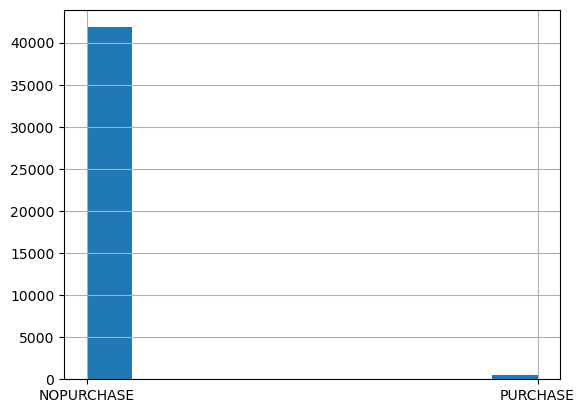

In [19]:
init_train['RESPONSE'].hist()

In [20]:
#Get Buyers
purchase_records = init_train[init_train['RESPONSE'] == 'PURCHASE']
#Get NonBuyer Records
no_purchase_records = init_train[init_train['RESPONSE'] == 'NOPURCHASE']

buyer_weight_multiplier = math.floor(len(no_purchase_records) / len(purchase_records))
print(f'buyer_weight_multiplier: {buyer_weight_multiplier}')
init_train['RECORD_WEIGHT'] = np.where(init_train.index.isin(purchase_records.index), buyer_weight_multiplier, 1)

buyer_weight_multiplier: 79


In [21]:
init_train.head()

,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ,RECORD_WEIGHT
0,NOPURCHASE,-0.685886,-0.732582,-0.861314,Female,1
1,NOPURCHASE,0.095057,-0.061514,0.904276,Female,1
2,NOPURCHASE,-1.253845,-1.179960,1.198541,Male,1
3,NOPURCHASE,-0.117927,-0.285203,-0.861314,Female,1
4,NOPURCHASE,-0.614891,-0.508892,0.021481,Male,1


In [22]:
init_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42357 entries, 0 to 42961
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   RESPONSE             42357 non-null  category
 1   LP_LEBENSPHASE_FEIN  42357 non-null  float64 
 2   LP_LEBENSPHASE_GROB  42357 non-null  float64 
 3   LP_STATUS_FEIN       42357 non-null  float64 
 4   ANREDE_KZ            42357 non-null  category
 5   RECORD_WEIGHT        42357 non-null  int64   
dtypes: category(2), float64(3), int64(1)
memory usage: 1.7 MB


In [23]:
init_train.describe()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,RECORD_WEIGHT
count,4.235700e+04,4.235700e+04,4.235700e+04,42357.000000
mean,-1.087026e-16,6.106135e-17,4.579601e-17,1.970465
std,1.000012e+00,1.000012e+00,1.000012e+00,8.646170
min,-1.253845e+00,-1.179960e+00,-1.449845e+00,1.000000
25%,-8.278756e-01,-7.325817e-01,-8.613144e-01,1.000000
50%,-1.889223e-01,-2.852030e-01,-2.727842e-01,1.000000
75%,1.017990e+00,1.056933e+00,9.042763e-01,1.000000
max,1.585948e+00,1.504312e+00,1.198541e+00,79.000000


In [24]:
#Buyer Record Head
purchase_records_head = init_train[init_train['RESPONSE'] == 'PURCHASE']
purchase_records_head.head()

,RESPONSE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,ANREDE_KZ,RECORD_WEIGHT
90,PURCHASE,1.585948,1.504312,1.198541,Female,79
129,PURCHASE,-0.614891,-0.508892,0.315746,Male,79
173,PURCHASE,1.514953,1.504312,1.198541,Male,79
205,PURCHASE,-0.117927,-0.285203,-0.861314,Male,79
248,PURCHASE,0.166052,-0.061514,1.198541,Male,79


### Doing Simple Training

In [25]:
# Normalize the weights
init_train['RECORD_WEIGHT'] /= init_train['RECORD_WEIGHT'].sum()
init_train['RECORD_WEIGHT'].describe()

count    42357.000000
mean         0.000024
std          0.000104
min          0.000012
25%          0.000012
50%          0.000012
75%          0.000012
max          0.000947
Name: RECORD_WEIGHT, dtype: float64

In [26]:
## Split Data into Training and Validation sets
init_train_data, init_test_data = train_test_split(init_train, test_size=0.2, random_state=1)

In [129]:
predictor = TabularPredictor(label="RESPONSE", verbosity=4, sample_weight='RECORD_WEIGHT', weight_evaluation=True).fit(
    train_data=init_train_data,
    time_limit=600,
    presets="best_quality"
)

In [133]:
model_path = predictor.path
print(f"The model was saved in: {model_path}")

The model was saved in: AutogluonModels/ag-20231202_165959


In [27]:
model_path = 'AutogluonModels/ag-20231202_165959'

In [28]:
predictor = TabularPredictor.load(model_path)

In [32]:
results = predictor.evaluate(init_test_data)
#since original Kaggle competition was based on roc_auc score I'll evaluate my models on the same score
base_training = results['roc_auc']
base_training

0.5381529481191072

In [105]:
base_training = 0.5381529481191072

In [33]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.546942    accuracy       0.439539   80.032187                0.065970          17.003350            2       True         13
1         LightGBMXT_BAG_L1   0.546836    accuracy       0.198783   22.908805                0.198783          22.908805            1       True          3
2           CatBoost_BAG_L1   0.544622    accuracy       0.063812   22.889361                0.063812          22.889361            1       True          7
3           LightGBM_BAG_L1   0.537115    accuracy       0.096161   21.718514                0.096161          21.718514            1       True          4
4     ExtraTreesEntr_BAG_L1   0.522239    accuracy       1.133869    2.390440                1.133869           2.390440            1       True          9
5 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.5076202174605342,
  'KNeighborsDist_BAG_L1': 0.5076202174605342,
  'LightGBMXT_BAG_L1': 0.546835903735044,
  'LightGBM_BAG_L1': 0.5371153875316561,
  'RandomForestGini_BAG_L1': 0.5222085740715469,
  'RandomF

## Clean Data Train
We have now gone using AWS DataWranger and pruned and transformed the data, will do a couple of training runs to see what our model scores are with a full set of data

In [73]:
# train_data = pd.read_csv(f'{s3_data_path}/clean-train-2023-12-06T09-16-12-large/part-00000-8862f7de-3757-4aca-b7bc-e0e4c5fc20b8-c000.csv')
train_data = pd.read_csv(f'{s3_data_path}/clean-large.csv')

#### Further Cleaning
Data Wrangler was having some issues with dropping na values so we'll do it here.

In [74]:
non_numeric_columns = train_data.select_dtypes(exclude=['number']).columns

label_encoder = LabelEncoder()

for column in non_numeric_columns:
    train_data[column] = label_encoder.fit_transform(train_data[column])

train_data.dropna(axis=1, inplace=True)

#### Set Weights For Records

In [75]:
#Categorize Target
train_data['RESPONSE'] = train_data['RESPONSE'].map({0: 'NOPURCHASE', 1: 'PURCHASE'}).astype('category')

In [76]:
#Get Buyers
purchase_records = train_data[train_data['RESPONSE'] == 'PURCHASE']
#Get NonBuyer Records
no_purchase_records = train_data[train_data['RESPONSE'] == 'NOPURCHASE']

buyer_weight_multiplier = math.floor(len(no_purchase_records) / len(purchase_records))
print(f'buyer_weight_multiplier: {buyer_weight_multiplier}')
train_data['RECORD_WEIGHT'] = np.where(train_data.index.isin(purchase_records.index), buyer_weight_multiplier, 1)

buyer_weight_multiplier: 77


In [77]:
train_data = train_data.drop('LNR', axis=1)

In [78]:
# Validation dataset is not neccisary for autogluon
clean_train_data, clean_test_data = train_test_split(train_data, test_size=0.2, random_state=1)

In [79]:
# Normalize the weights
clean_train_data['RECORD_WEIGHT'] /= clean_train_data['RECORD_WEIGHT'].sum()

In [57]:
predictor_clean = TabularPredictor(label="RESPONSE", sample_weight='RECORD_WEIGHT', weight_evaluation=True).fit(
    train_data=clean_train_data,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231211_191700"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20231211_191700/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 171 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 429 seconds.
Starting full fit now with num_stack_leve

In [59]:
clean_data_results = predictor_clean.evaluate(clean_test_data)
clean_data_results

{'accuracy': 0.46005830903790085,
 'balanced_accuracy': 0.4987357774968395,
 'mcc': -0.03693040413357511,
 'roc_auc': 0.6281078803202698,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}

In [99]:
clean_data_results_all_features = 0.6281078803202698

## Feature Selection
In this section I'm gonna run through the full feature set and select the top 10 percentile features that are predicted to coorilate to a customer PURCHASE.

I went ahead and cleaned the train data via several steps in data wrangler (dropped columns that didn't fit what I had in the attributes sheet, filled in empty values, changed data types, dropped columns that didn't have values). The specifics of what was done can be analyzed in clean_train.flow.

In [80]:
non_features = ['RESPONSE', 'EINGEFUEGT_AM', 'RECORD_WEIGHT']
features = train_data.columns[~train_data.columns.isin(non_features)]

In [81]:
X, y = train_data[features], train_data['RESPONSE']

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# X_abs = X.abs()
selector = SelectPercentile(f_classif, percentile=90)

selected_features = selector.fit_transform(X, y)

In [86]:
X, y = train_data[features], train_data['RESPONSE']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_abs = X.abs()
selector = SelectPercentile(chi2, percentile=90)

selected_features = selector.fit_transform(X_abs, y)

In [87]:
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = np.array(features)[selected_feature_indices]
print(selected_feature_names)

['AGER_TYP' 'ALTER_HH' 'ALTERSKATEGORIE_FEIN' 'ANZ_HAUSHALTE_AKTIV'
 'ANZ_HH_TITEL' 'ANZ_PERSONEN' 'ANZ_STATISTISCHE_HAUSHALTE' 'BALLRAUM'
 'CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015' 'D19_BANKEN_ANZ_12'
 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM' 'D19_BANKEN_OFFLINE_DATUM'
 'D19_BANKEN_ONLINE_DATUM' 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST'
 'D19_BEKLEIDUNG_GEH' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAUS_DEKO'
 'D19_KINDERARTIKEL' 'D19_KONSUMTYP' 'D19_KOSMETIK' 'D19_LEBENSMITTEL'
 'D19_LETZTER_KAUF_BRANCHE' 'D19_LOTTO' 'D19_NAHRUNGSERGAENZUNG'
 'D19_RATGEBER' 'D19_REISEN' 'D19_SAMMELARTIKEL' 'D19_SCHUHE'
 'D19_SONSTIGE' 'D19_TECHNIK' 'D19_TELKO_ANZ_24' 'D19_TELKO_DATUM'
 'D19_TELKO_MOBILE' 'D19_TELKO_OFFLINE_DATUM' 'D19_TELKO_ON

### Training Run
Now that we have what are top 10% features are we're going to run through and do a training job

In [88]:
training_coulmns = np.concatenate((selected_feature_names, non_features))

selected_features_train_data = clean_train_data[training_coulmns].copy()
selected_features_test_data = clean_test_data[training_coulmns].copy()

### Method Eveluation
Next we'll run two training jobs evaluating if the weighting method or the log_loss method returns the best roc_auc score

#### Weighted Training Run

In [89]:
predictor_w = TabularPredictor(label="RESPONSE", sample_weight='RECORD_WEIGHT', weight_evaluation=True).fit(
    train_data=selected_features_train_data,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231211_195835"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20231211_195835/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 185 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 415 seconds.
Starting full fit now with num_stack_leve

In [90]:
weight_results = predictor_w.evaluate(selected_features_test_data)
weight_results

{'accuracy': 0.4227405247813411,
 'balanced_accuracy': 0.4582806573957017,
 'mcc': -0.21622673163619519,
 'roc_auc': 0.5163822166034555,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}

In [ ]:
f_classif_feature_train_results = {
    'accuracy': 0.46122448979591835,
    'balanced_accuracy': 0.5,
    'mcc': 0.0,
    'roc_auc': 0.5702697008006743,
    'f1': 0.0,
    'precision': 0.0,
    'recall': 0.0
}

In [ ]:
chi2_feature_train_results = {
    'accuracy': 0.4227405247813411,
    'balanced_accuracy': 0.4582806573957017,
    'mcc': -0.21622673163619519,
    'roc_auc': 0.5163822166034555,
    'f1': 0.0,
    'precision': 0.0,
    'recall': 0.0
}

In [100]:
f_classif_feature_train_results = 0.5702697008006743

In [101]:
chi2_feature_train_results = 0.5163822166034555

In [28]:
predictor_w.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L2   0.717317    accuracy       0.126499  69.796628                0.006395           4.718000            2       True         18
1               CatBoost_BAG_L1   0.711324    accuracy       0.035699  20.721645                0.035699          20.721645            1       True          7
2          CatBoost_r177_BAG_L1   0.709218    accuracy       0.035005  22.401947                0.035005          22.401947            1       True         14
3             LightGBMXT_BAG_L1   0.688968    accuracy       0.049399  21.955037                0.049399          21.955037            1       True          3
4               LightGBM_BAG_L1   0.592743    accuracy       0.036551  18.621748                0.036551          18.621748            1       

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiT

### Lower Weight Training Run

In [91]:
buyer_weight_multiplier = 10
print(f'buyer_weight_multiplier: {buyer_weight_multiplier}')
clean_train_data['RECORD_WEIGHT'] = np.where(clean_train_data.index.isin(purchase_records.index), buyer_weight_multiplier, 1)

buyer_weight_multiplier: 10


In [92]:
# Normalize the weights
clean_train_data['RECORD_WEIGHT'] /= clean_train_data['RECORD_WEIGHT'].sum()
clean_train_data['RECORD_WEIGHT'].describe()

count    3209.000000
mean        0.000312
std         0.000277
min         0.000281
25%         0.000281
50%         0.000281
75%         0.000281
max         0.002809
Name: RECORD_WEIGHT, dtype: float64

In [93]:
purchase_records_head = clean_train_data[clean_train_data['RESPONSE'] == 'PURCHASE']
purchase_records_head.head()

,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,RECORD_WEIGHT
2721,2,9,9,1,0,1,1,6,0,6,...,4,1,5,1,2,3,PURCHASE,2,4,0.002809
1554,2,9,9,9,0,1,9,2,12,5,...,5,3,2,3,2,3,PURCHASE,2,4,0.002809
2926,2,19,11,12,0,4,14,7,11,8,...,6,2,7,2,1,3,PURCHASE,1,4,0.002809
499,-1,0,9,1,0,1,1,6,0,6,...,2,3,1,-1,-1,3,PURCHASE,2,1,0.002809
3435,2,15,9,1,0,5,1,6,15,3,...,6,2,7,3,1,3,PURCHASE,1,4,0.002809


In [94]:
predictor_w = TabularPredictor(label="RESPONSE", verbosity=4, sample_weight='RECORD_WEIGHT', weight_evaluation=True).fit(
    train_data=clean_train_data,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231211_201315"
Presets specified: ['best_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True, 'num_bag_sets': 1}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'holdout_data': None,
             'holdout_frac': 0.1111111111111111,
             'memory_safe_fits': True,
             'n_folds': 2,
             'n_repeats': 1,
             'validation_procedure': 'holdout'},
 'excluded_model_types': None,
 'feature_generator': 'auto',
 'feature_prune_kwargs': None,
 'holdout_frac': None,
 'hyperparameter_tune_kwargs': None,
 'included_model_types': None,
 'keep_only_best': False,
 'name_suffix': None,
 'num_bag_folds': None,
 'num_bag_sets': 1,
 'num_stack_l

In [95]:
lw_weight_results = predictor_w.evaluate(clean_test_data)
lw_weight_results

Loading: AutogluonModels/ag-20231211_201315/models/CatBoost_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/ExtraTreesEntr_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/ExtraTreesGini_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/KNeighborsDist_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/KNeighborsUnif_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/LightGBMLarge_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/LightGBMXT_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/LightGBM_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/NeuralNetFastAI_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/NeuralNetTorch_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/RandomForestEntr_BAG_L1/model.pkl
Loading: AutogluonModels/ag-20231211_201315/models/RandomForestGini_BAG_L1/model.pkl
Loading: Autoglu

{'accuracy': 0.46122448979591835,
 'balanced_accuracy': 0.5,
 'mcc': 0.0,
 'roc_auc': 0.5018963337547409,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}

In [102]:
lw_weight_training = 0.5018963337547409

### Log Loss model with not weights

In [96]:
final_train_data_ll = clean_test_data.drop('RECORD_WEIGHT', axis=1)
final_test_data_ll = clean_test_data.drop('RECORD_WEIGHT', axis=1)

In [97]:
predictor_ll = TabularPredictor(label="RESPONSE", eval_metric="log_loss").fit(
    train_data=final_train_data_ll,
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231211_202441"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20231211_202441/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 166 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 434 seconds.
Starting full fit now with num_stack_leve

In [98]:
ll_results = predictor_w.evaluate(final_test_data_ll)
ll_results

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.9850560398505604,
 'balanced_accuracy': 0.5,
 'mcc': 0.0,
 'roc_auc': 0.5018963337547409,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0}

In [103]:
ll_training = 0.5018963337547409

In [32]:
predictor_ll.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                        model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L2  -0.058076    log_loss       0.651895  201.582013                0.001327           1.717411            2       True         17
1       NeuralNetTorch_BAG_L1  -0.060804    log_loss       0.283464   72.004302                0.283464          72.004302            1       True         12
2           LightGBMXT_BAG_L1  -0.062662    log_loss       0.030965   27.692625                0.030965          27.692625            1       True          3
3      NeuralNetFastAI_BAG_L1  -0.062673    log_loss       0.174960   55.708832                0.174960          55.708832            1       True         10
4        CatBoost_r177_BAG_L1  -0.062835    log_loss       0.012231   23.584340                0.012231          23.584340            1       True  

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_perfo

### Best Method to use
Chart the results to see which is the best to deploy

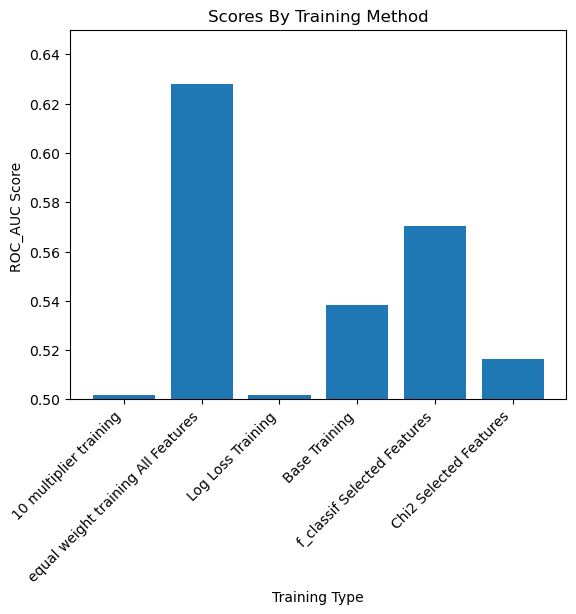

In [106]:
# Values for the bars
values = [lw_weight_training, clean_data_results_all_features, ll_training, base_training, f_classif_feature_train_results, chi2_feature_train_results]

# Names for the bars
categories = ['10 multiplier training', 'equal weight training All Features', 'Log Loss Training', 'Base Training', 'f_classif Selected Features', 'Chi2 Selected Features']

plt.bar(categories, values, width=0.2, color='blue')

# Create a bar chart
plt.bar(categories, values)

plt.ylim(0.5, 0.65)

# Add labels and title
plt.xlabel('Training Type')
plt.ylabel('ROC_AUC Score ')
plt.title('Scores By Training Method')
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.show()

From the above analysis of ROC_AUC scores it seems that we should go with the equal weight training while leaving in all the feautres and not prune any further.

## Train and Deploy to Endpoint

### Retrieve AutoGluon Image
https://docs.aws.amazon.com/sagemaker/latest/dg/autogluon-tabular.html

https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/autogluon_tabular/Amazon_Tabular_Classification_AutoGluon.ipynb

In [107]:
clean_train_data.to_csv('data/final_train_data.csv')
copy_command = f'aws s3 cp data/final_train_data.csv {s3_data_path}/final_train_data.csv'
!{copy_command}

upload: data/final_train_data.csv to s3://sagemaker-us-east-1-366182757343/data/final_train_data.csv


In [108]:
train_model_id, train_model_version, train_scope = "autogluon-classification-ensemble", "*", "training"
training_instance_type = "ml.m5.large"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)


Using model 'autogluon-classification-ensemble' with wildcard version identifier '*'. You can pin to version '2.0.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [112]:
script_path = 'train.py'
model_output_path = f'{s3_model_path}'

# Create an Estimator
estimator = Estimator(
    role=execution_role,
    image_uri=train_image_uri,
    entry_point=script_path,
    train_instance_count=1,
    train_instance_type=training_instance_type,
    output_path=model_output_path,
)

data_channels = {
   'train': f'{s3_data_path}/final_train_data.csv'
}

estimator.fit(inputs=data_channels)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: autogluon-training-2023-12-11-21-29-28-246


2023-12-11 21:29:28 Starting - Starting the training job...
2023-12-11 21:29:44 Starting - Preparing the instances for training.........
2023-12-11 21:31:13 Downloading - Downloading input data...
2023-12-11 21:31:43 Training - Downloading the training image......
2023-12-11 21:32:53 Training - Training image download completed. Training in progress..2023-12-11 21:32:54,694 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2023-12-11 21:32:54,696 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-11 21:32:54,705 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.m5.large","hosts":["algo-1"],"instance_groups":[{"hosts":["algo-1"],

In [115]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
model_location = estimator.model_data
# model_location = 's3://sagemaker-us-east-1-709677954768/autogluon-training-2023-12-08-18-01-16-720/'
print(f"Weight Trained Model: {weight_model_location}")

Training jobname: autogluon-training-2023-12-11-21-29-28-246
Weight Trained Model: s3://sagemaker-us-east-1-366182757343/model/autogluon-training-2023-12-11-21-29-28-246/output/model.tar.gz


https://auto.gluon.ai/0.4.0/tutorials/cloud_fit_deploy/cloud-aws-sagemaker-deployment.html

In [116]:
endpoint_name = sagemaker.utils.unique_name_from_base("sagemaker-autogluon-serving-trained-model")
endpoint_name

'sagemaker-autogluon-serving-trained-model-1702330958-1cc4'

In [135]:
instance_type = "ml.m5.large"

model = AutoGluonSagemakerInferenceModel(
    model_data=model_location,
    role=execution_role,
    region=region,
    framework_version="0.3.1",
    instance_type=instance_type,
    source_dir="scripts",
    entry_point="tabular_serve.py",
    py_version="py37"
)

predictor = model.deploy(
    initial_instance_count=1, serializer=CSVSerializer(), instance_type=instance_type
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-366182757343/model/autogluon-training-2023-12-11-21-29-28-246/output/model.tar.gz), script artifact (scripts), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-366182757343/autogluon-inference-2023-12-11-22-12-33-580/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: autogluon-inference-2023-12-11-22-13-02-533
INFO:sagemaker:Creating endpoint-config with name autogluon-inference-2023-12-11-22-13-03-293
INFO:sagemaker:Creating endpoint with name autogluon-inference-2023-12-11-22-13-03-293


-----!